# 2020 Airbnb Analysis

This notebook details the approaches used and recommendations arrived at when evaluating the impact of price, type of room, minimum night stay, availability, neighborhood, and instant booking feature on Airbnb ratings. 

It also seeks to understand the relationship between review comments and review rating for Airbnbs in Los Angeles, CA. Comment text is used to predict review ratings.

The date range of the review data ranges from January 2019 to November 2020. Only hosts with one property and listing with nightly prices of $300 or less were included in the analysis to ensure similarity in listings being assessed.


This notebook is broken into 4 parts: 

PART 1 - DATA CLEANING

PART 2 - DATA EXPLORATION 

PART 3 - DATA ANALYSIS

PART 4 - RECOMMENDATIONS

## PART 1 - DATA CLEANING

Listing and review level data is pulled into the notebook. In listing level data, ratings of value, communication,and location are summed into one variable titled, "aggregate_review_score." Listing level data is joined with review level data on listing id to later predict listing ratings by review text.

Review level data contains a review date. The number of reviews pre 3/31/2020 and the number of reviews post 3/31/2020 are calculated in order to assess the change in total reviews per listing post COVID.

### Importing pandas, matplotlib, and seaborn, etc.

In [161]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections
import re, string
import sys
import time
from nltk.corpus import stopwords

%matplotlib inline

### Pulling in data, merging listing level data

In [162]:
listings = pd.read_csv('data/listings.csv',
                   parse_dates=['last_review'])
listings = listings[listings['number_of_reviews']>200]
listings['last_review_year'] = [str(i.year) for i in listings.last_review]
listings['last_review_year'] = listings['last_review_year'].astype(int) 
listings = listings[listings['last_review_year']>=2019]
listings = listings[listings['calculated_host_listings_count']==1]
listings = listings[listings['price']<=300]

listings_detail = pd.read_csv('data/listings-2.csv')
reviews = pd.read_csv('data/reviews-2.csv', parse_dates=['date'])
listing_level_data = pd.merge(listings, listings_detail, on='id', how='inner')
listing_level_data.rename(columns = {'id':'listing_id'}, inplace = True)

### Calculating aggregate review score in listing level data by summing communication, location, and value

In [163]:
aggregate_review_score = listing_level_data["review_scores_communication"] + listing_level_data["review_scores_location"] + listing_level_data["review_scores_value"]

listing_level_data["aggregate_reviews"] = aggregate_review_score

### Pulling in review level data, merging review and listing level data

In [164]:
reviews = pd.read_csv('data/reviews-2.csv', parse_dates=['date'])
reviews['year'] = [str(i.year) for i in reviews.date]
reviews['month'] = [str(i.month) for i in reviews.date]
reviews['year'] = reviews['year'].astype(int) 
reviews = reviews[reviews['year']>=2019]
review_level_data = pd.merge(reviews, listing_level_data, on='listing_id', how='inner')

### Identifying net change in total reviews pre and post COVID

In [165]:
review_level_data.insert(1, 'Count_Use', 1)

start_date = "2020-3-1"

datafromcohort1 = review_level_data[review_level_data["date"] <= start_date].groupby('listing_id').Count_Use.sum()
datafromcohort2 = review_level_data[review_level_data["date"] > start_date].groupby('listing_id').Count_Use.sum()

prior_year_date = "2019-3-1"

datafromcohort1 = review_level_data[review_level_data["date"] >= prior_year_date].groupby('listing_id').Count_Use.sum()

current_year_date = "2020-3-1"

datafromcohort2 = review_level_data[review_level_data["date"] >= current_year_date].groupby('listing_id').Count_Use.sum()

review_total_change = pd.merge(datafromcohort1, datafromcohort2, on='listing_id', how='inner')
review_total_change.head()

review_total_change['review_change'] = review_total_change.apply(lambda x: x['Count_Use_y'] - x['Count_Use_x'], axis=1)

reviews_cohort_1 = pd.merge(review_level_data, review_total_change, on='listing_id', how='outer')

listing_level_data = pd.merge(listing_level_data, review_total_change, on='listing_id', how='outer')

### Examining listing and review level dataframes

In [166]:
listing_level_data.head()

,listing_id,name_x,host_id_x,host_name_x,neighbourhood_group,neighbourhood_x,latitude_x,longitude_x,room_type_x,price_x,...,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month_y,aggregate_reviews,Count_Use_x,Count_Use_y,review_change
0,8770,Cozy Guest House on Venice Walk St.,26996,Lillian,City of Los Angeles,Venice,33.99399,-118.45637,Entire home/apt,122,...,f,1,1,0,0,3.02,29.0,NaN,NaN,NaN
1,9140,City Place Lofts,28350,Wendell,Other Cities,Long Beach,33.77206,-118.18893,Private room,80,...,t,1,0,1,0,4.23,30.0,NaN,NaN,NaN
2,20585,"Private Studio, 6 Doors to Beach",77857,Barbara,City of Los Angeles,Venice,33.98012,-118.46490,Entire home/apt,124,...,f,1,1,0,0,3.75,30.0,66.0,7.0,-59.0
3,23710,Green Sputnik in Highland Park,94038,Tatiana,City of Los Angeles,Highland Park,34.12003,-118.19038,Entire home/apt,108,...,t,1,1,0,0,2.10,NaN,102.0,7.0,-95.0
4,24030,Beach Bungalow one block to ocean,96147,Michaela,City of Los Angeles,Venice,33.98798,-118.47301,Entire home/apt,130,...,f,1,1,0,0,5.46,30.0,NaN,NaN,NaN


In [167]:
review_level_data.head()

,listing_id,Count_Use,id,date,reviewer_id,reviewer_name,comments,year,month,name_x,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month_y,aggregate_reviews
0,8770,1,404103410,2019-01-22,17427433,Miles,On one of the beautiful Venice walk streets th...,2019,1,Cozy Guest House on Venice Walk St.,...,10.0,9.0,HSR19-003129,f,1,1,0,0,3.02,29.0
1,8770,1,422998649,2019-03-12,3571431,Julianne,This listing is in a GARAGE and windows overlo...,2019,3,Cozy Guest House on Venice Walk St.,...,10.0,9.0,HSR19-003129,f,1,1,0,0,3.02,29.0
2,8770,1,426037940,2019-03-19,124656,Penelope,Lilian's guest house is nestled in one of the ...,2019,3,Cozy Guest House on Venice Walk St.,...,10.0,9.0,HSR19-003129,f,1,1,0,0,3.02,29.0
3,8770,1,429078909,2019-03-26,11791130,Susan,Lillian’s place is in a very quiet location wi...,2019,3,Cozy Guest House on Venice Walk St.,...,10.0,9.0,HSR19-003129,f,1,1,0,0,3.02,29.0
4,8770,1,434436768,2019-04-07,192884362,Charles,Lillian is an awesome host. Very cute place ve...,2019,4,Cozy Guest House on Venice Walk St.,...,10.0,9.0,HSR19-003129,f,1,1,0,0,3.02,29.0


In [168]:
listing_level_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 0 to 481
Data columns (total 94 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   listing_id                                    482 non-null    int64         
 1   name_x                                        482 non-null    object        
 2   host_id_x                                     482 non-null    int64         
 3   host_name_x                                   482 non-null    object        
 4   neighbourhood_group                           482 non-null    object        
 5   neighbourhood_x                               482 non-null    object        
 6   latitude_x                                    482 non-null    float64       
 7   longitude_x                                   482 non-null    float64       
 8   room_type_x                                   482 non-null    object  

In [169]:
listing_level_data.dropna(inplace=True)

In [170]:
review_level_data.dropna(inplace=True)

## PART 2 - DATA EXPLORATION

Data is explored for trends by year, season, neighborhood, availability, and price.

### Goal: Plotting total number of reviews by area 

### Takeaway: The majority of bookings are in the city of Los Angeles, rather than surrounding cities. Little difference in average location or value rating is observed based on whether the listing is in Los Angeles or in surrounding cities. 

IndexError: index 0 is out of bounds for axis 0 with size 0

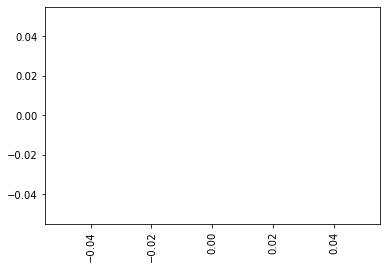

In [172]:
listing_level_data.aggregate_reviews.value_counts().plot(kind = 'bar')

plt.title('Number Of Reviews per Aggregate Rating', size = 20)
plt.xlabel('Rating', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

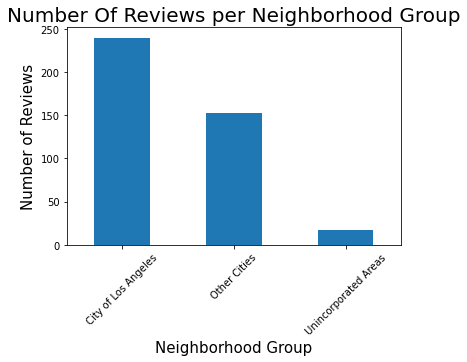

In [80]:
listing_level_data.neighbourhood_group.value_counts().plot(kind = 'bar')

plt.title('Number Of Reviews per Neighborhood Group', size = 20)
plt.xlabel('Neighborhood Group', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

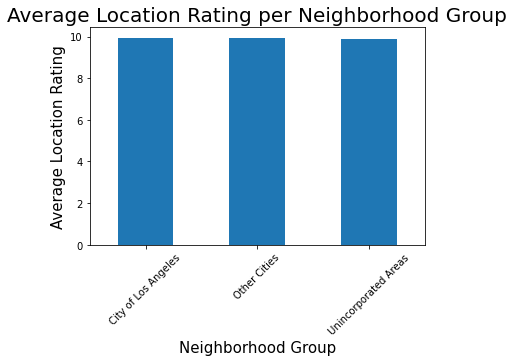

neighbourhood_group
City of Los Angeles     9.920833
Other Cities            9.947712
Unincorporated Areas    9.882353
Name: review_scores_location, dtype: float64

In [81]:
listing_level_data.groupby('neighbourhood_group').review_scores_location.mean().plot(kind = 'bar')

plt.title('Average Location Rating per Neighborhood Group', size = 20)
plt.xlabel('Neighborhood Group', size = 15)
plt.ylabel('Average Location Rating', size = 15)
plt.xticks(rotation=45)

plt.show()

listing_level_data.groupby('neighbourhood_group').review_scores_location.mean()

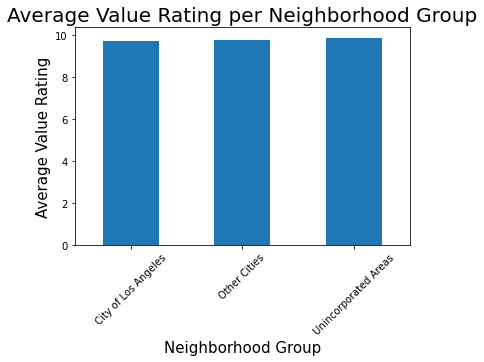

neighbourhood_group
City of Los Angeles     9.920833
Other Cities            9.947712
Unincorporated Areas    9.882353
Name: review_scores_location, dtype: float64

In [82]:
listing_level_data.groupby('neighbourhood_group').review_scores_value.mean().plot(kind = 'bar')

plt.title('Average Value Rating per Neighborhood Group', size = 20)
plt.xlabel('Neighborhood Group', size = 15)
plt.ylabel('Average Value Rating', size = 15)
plt.xticks(rotation=45)

plt.show()

listing_level_data.groupby('neighbourhood_group').review_scores_location.mean()

### Goal: plotting reviews by month to assess for seasonality in 2019

### Takeaway: There is some seasonality in 2019, with fewer bookings in the winter months

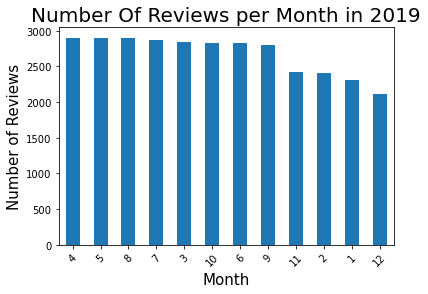

In [83]:
review_level_data[review_level_data['year']==2019].month.value_counts().plot(kind = 'bar')

plt.title('Number Of Reviews per Month in 2019', size = 20)
plt.xlabel('Month', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

### Goal: plotting reviews by month to assess for seasonality in 2020

### Takeaway: In 2020, earlier months of the year pre COVID have the most bookings. This represents a change from 2019.

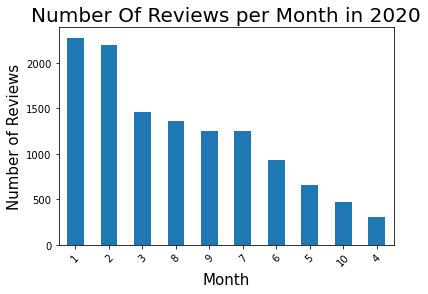

In [84]:
review_level_data[review_level_data['year']==2020].month.value_counts().plot(kind = 'bar')

plt.title('Number Of Reviews per Month in 2020', size = 20)
plt.xlabel('Month', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

### Goal: Plot reviews by date to assess for trend over time

### Takeaway: Data shows a large drop off in reviews starting in March 2020 (beginning of COVID), followed by a slight climb throughout the year. Overall, fewer than half the number of reviews seen in 2019 were observed in 2020, even with most of the 2020 calendar year complete. 

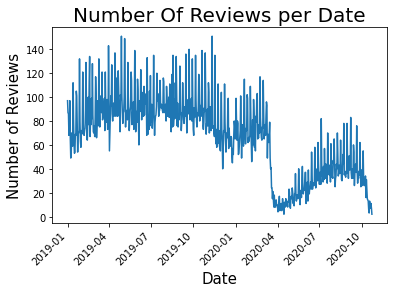

In [85]:
review_level_data.date.value_counts().plot(kind = 'line')

plt.title('Number Of Reviews per Date', size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

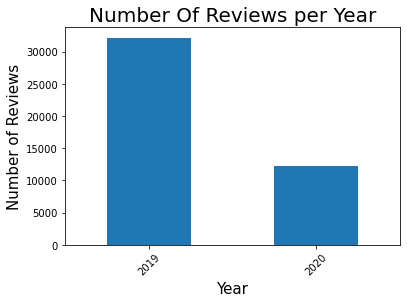

In [86]:
review_level_data.year.value_counts().plot(kind = 'bar')

plt.title('Number Of Reviews per Year', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Number of Reviews', size = 15)
plt.xticks(rotation=45)

plt.show()

### Goal: View distribution of the change in number of reviews per listing post covid

### Takeaway: Almost all listings have had a decrease in reviews post COVID. Mean net change in number of reviews post COVID is -64. The top quartile of listings with the lowest decrease in reviews post COVID saw a decrease of 48 reviews or fewer after March 2020. 

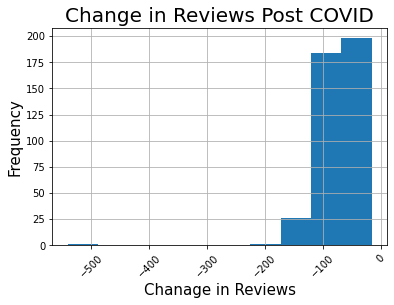

In [87]:
listing_level_data.review_change.hist()

plt.title('Change in Reviews Post COVID', size = 20)
plt.xlabel('Chanage in Reviews', size = 15)
plt.ylabel('Frequency', size = 15)
plt.xticks(rotation=45)

plt.show()

In [88]:
listing_level_data.review_change.describe()

count    410.000000
mean     -73.321951
std       36.876703
min     -541.000000
25%      -86.750000
50%      -68.000000
75%      -51.250000
max      -15.000000
Name: review_change, dtype: float64

In [89]:
bins = [-541, -87, -68, -51, np.inf]
names = ['Bottom Quartile', 'Third Quartile', 'Second Quartile', 'Top Quartile']

listing_level_data['review_change_quartile'] = pd.cut(listing_level_data['review_change'], bins, labels=names)

listing_level_data.groupby('review_change_quartile').review_change.max()

review_change_quartile
Bottom Quartile   -87.0
Third Quartile    -68.0
Second Quartile   -51.0
Top Quartile      -15.0
Name: review_change, dtype: float64

In [90]:
listing_level_data = listing_level_data[listing_level_data['Count_Use_x']>50]

In [91]:
listing_level_data.head()

,listing_id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,instant_bookable,calculated_host_listings_count_y,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,aggregate_reviews,Count_Use_x,Count_Use_y,review_change,review_change_quartile
2,20585,"Private Studio, 6 Doors to Beach",77857,Barbara,City of Los Angeles,Venice,33.98012,-118.46490,Entire home/apt,124,...,f,1,1,0,0,30.0,66.0,7.0,-59.0,Second Quartile
8,54829,Beautiful Venice Beach Home Oasis,257925,Yvonne,City of Los Angeles,Venice,34.00061,-118.46353,Entire home/apt,125,...,t,1,1,0,0,30.0,106.0,14.0,-92.0,Bottom Quartile
9,69838,L.A. Lifestyle--like you live here,351521,Sterling,City of Los Angeles,Mid-City,34.03853,-118.33628,Private room,89,...,f,1,0,1,0,30.0,79.0,11.0,-68.0,Third Quartile
10,79832,Guest Quarters @ the Hollywood Sign,28569,Robert,City of Los Angeles,Hollywood Hills,34.12920,-118.31905,Entire home/apt,110,...,f,1,1,0,0,30.0,54.0,5.0,-49.0,Top Quartile
12,107970,2 Room Poolside Guesthouse +bikes,552845,Ronan,Other Cities,Long Beach,33.77435,-118.12275,Entire home/apt,45,...,f,1,1,0,0,28.0,155.0,53.0,-102.0,Bottom Quartile


In [92]:
listing_level_data.groupby('host_id').Count_Use_x.value_counts(200)

host_id    Count_Use_x
28569      54.0           1.0
61692      93.0           1.0
77857      66.0           1.0
103790     76.0           1.0
120950     84.0           1.0
                         ... 
198927270  128.0          1.0
207839860  170.0          1.0
212312556  74.0           1.0
248540707  209.0          1.0
356854066  86.0           1.0
Name: Count_Use_x, Length: 354, dtype: float64

## PART 3 - DATA ANALYSIS

Regression analysis is first run on listing level data to create a predictive model and to evaluate top factors associated with better review ratings.

Review level comment text is then vectorized and regression analysis is run to determine the association between key words from review comments and review ratings.

### Goal: Run regression analysis to determine factors predicting review ratings

### Takeaway: Price is the most relevant feature in predicting review ratings, followed by the number of days open per year

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

all_listings = listing_level_data.dropna()

cols = ['price', 'neighbourhood', 'room_type', 'minimum_nights', 'availability_365']

X = all_listings[cols]
y = all_listings.aggregate_reviews

X = pd.get_dummies(X)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Accuracy Score
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/Kim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [98]:
predictions = lr.predict(X_train)
metrics.accuracy_score(predictions, y_train)

0.7588652482269503

In [99]:
print(f'Model Error: {metrics.mean_squared_error(lr.predict(X), y)}')
print(f'Benchmark: {metrics.mean_squared_error([y.mean() for i in range(len(y))], y)}')

Model Error: 0.7252124645892352
Benchmark: 0.5811137237278206


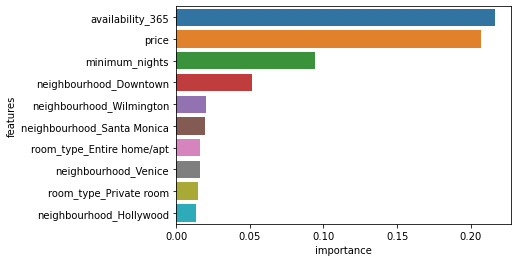

In [100]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

X.columns
rf.feature_importances_[:5]
df = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending= False)
sns.barplot(x = 'importance', y = 'features', data = df.head(10), orient='h')

### Goal: Further evaluate the impact of price and available days on review ratings and see if these factors have an impact on review ratings

### Takeaway: Data shows little change in price or days available from 2019 to 2020. Listings with a value score of 10 had slightly lower nightly prices than listings with a value score of less than 10. Listings that had overall higher review scores were typically open fewer days a year than those that had lower overall review scores. Listings that were available to book only one night tended to have lower review ratings.

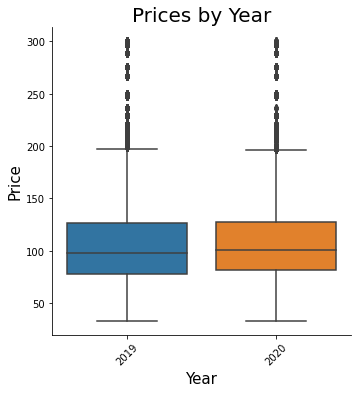

In [101]:
sns.catplot(data = review_level_data,kind = 'box' 
            ,x ='year', y = 'price')
plt.title('Prices by Year', size = 20)
plt.xlabel('Year' , size = 15)
plt.ylabel('Price', size = 15)
plt.xticks(rotation=45)

plt.show()

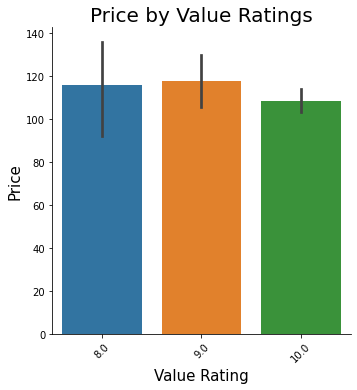

In [102]:
sns.catplot(data = listing_level_data,kind = 'bar' 
            ,x ='review_scores_value', y = 'price')
plt.title('Price by Value Ratings', size = 20)
plt.xlabel('Value Rating' , size = 15)
plt.ylabel('Price', size = 15)
plt.xticks(rotation=45)

plt.show()

In [103]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['review_scores_value'] == 10].price,
         listing_level_data[listing_level_data['review_scores_value'] <= 9].price)

Ttest_indResult(statistic=-1.5567685763775674, pvalue=0.12042404535239049)

In [104]:
listing_level_data.groupby('review_scores_value').price.mean()

review_scores_value
8.0     116.000000
9.0     117.898734
10.0    108.591912
Name: price, dtype: float64

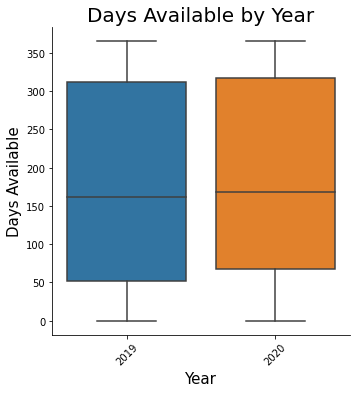

In [105]:
sns.catplot(data = review_level_data,kind = 'box' 
            ,x ='year', y = 'availability_365')
plt.title('Days Available by Year', size = 20)
plt.xlabel('Year' , size = 15)
plt.ylabel('Days Available', size = 15)
plt.xticks(rotation=45)

plt.show()

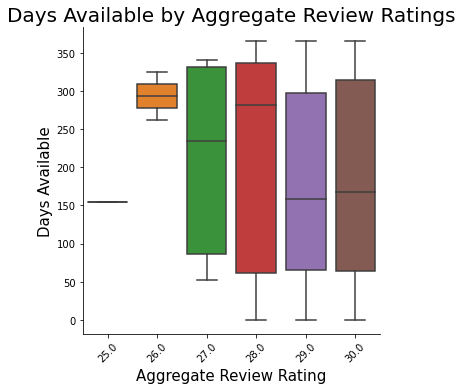

In [106]:
sns.catplot(data = listing_level_data,kind = 'box' 
            ,x ='aggregate_reviews', y = 'availability_365')
plt.title('Days Available by Aggregate Review Ratings', size = 20)
plt.xlabel('Aggregate Review Rating' , size = 15)
plt.ylabel('Days Available', size = 15)
plt.xticks(rotation=45)

plt.show()

In [107]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['aggregate_reviews'] == 30].availability_365,
         listing_level_data[listing_level_data['aggregate_reviews'] <= 29].availability_365)

Ttest_indResult(statistic=-0.8233029747233523, pvalue=0.41089315201299137)

In [108]:
listing_level_data.groupby('aggregate_reviews').availability_365.mean()

aggregate_reviews
25.0    154.000000
26.0    293.500000
27.0    210.500000
28.0    215.142857
29.0    181.967213
30.0    180.912548
Name: availability_365, dtype: float64

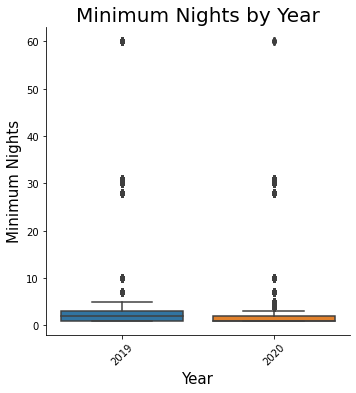

In [109]:
sns.catplot(data = review_level_data,kind = 'box' 
            ,x ='year', y = 'minimum_nights')
plt.title('Minimum Nights by Year', size = 20)
plt.xlabel('Year' , size = 15)
plt.ylabel('Minimum Nights', size = 15)
plt.xticks(rotation=45)

plt.show()

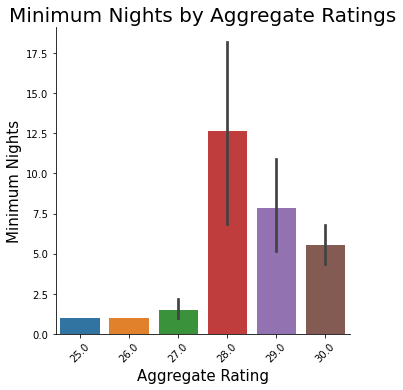

In [110]:
sns.catplot(data = listing_level_data,kind = 'bar' 
            ,x ='aggregate_reviews', y = 'minimum_nights')
plt.title('Minimum Nights by Aggregate Ratings', size = 20)
plt.xlabel('Aggregate Rating' , size = 15)
plt.ylabel('Minimum Nights', size = 15)
plt.xticks(rotation=45)

plt.show()

In [111]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['aggregate_reviews'] == 30].minimum_nights,
         listing_level_data[listing_level_data['aggregate_reviews'] <= 29].minimum_nights)

Ttest_indResult(statistic=-2.209356547438481, pvalue=0.027793222060247924)

In [112]:
listing_level_data.groupby('aggregate_reviews').minimum_nights.mean()

aggregate_reviews
25.0     1.000000
26.0     1.000000
27.0     1.500000
28.0    12.619048
29.0     7.836066
30.0     5.532319
Name: minimum_nights, dtype: float64

In [113]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['review_change_quartile'] == 'Top Quartile'].price,
         listing_level_data[listing_level_data['review_change_quartile'] == 'Bottom Quartile'].price)

Ttest_indResult(statistic=2.805427492920986, pvalue=0.00573536103410636)

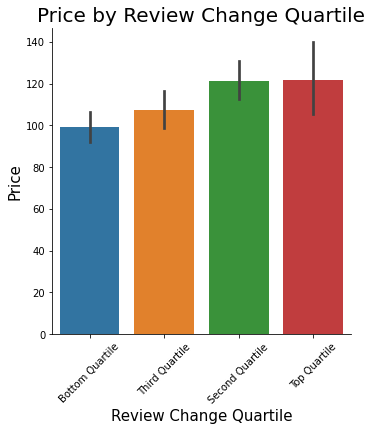

In [114]:
sns.catplot(data = listing_level_data,kind = 'bar' 
            ,x ='review_change_quartile', y = 'price')
plt.title('Price by Review Change Quartile', size = 20)
plt.xlabel('Review Change Quartile' , size = 15)
plt.ylabel('Price', size = 15)
plt.xticks(rotation=45)

plt.show()

In [115]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['review_change_quartile'] == 'Top Quartile'].minimum_nights,
         listing_level_data[listing_level_data['review_change_quartile'] == 'Bottom Quartile'].minimum_nights)

Ttest_indResult(statistic=1.4981816084994612, pvalue=0.13632150874353238)

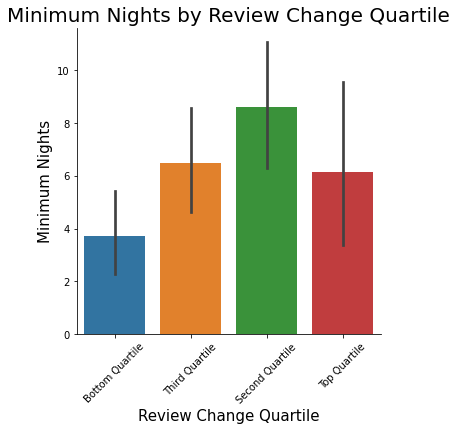

In [116]:
sns.catplot(data = listing_level_data,kind = 'bar' 
            ,x ='review_change_quartile', y = 'minimum_nights')
plt.title('Minimum Nights by Review Change Quartile', size = 20)
plt.xlabel('Review Change Quartile' , size = 15)
plt.ylabel('Minimum Nights', size = 15)
plt.xticks(rotation=45)

plt.show()

In [117]:
from scipy.stats import ttest_ind

ttest_ind(listing_level_data[listing_level_data['review_change_quartile'] == 'Top Quartile'].availability_365,
         listing_level_data[listing_level_data['review_change_quartile'] == 'Bottom Quartile'].availability_365)

Ttest_indResult(statistic=2.4131331181317073, pvalue=0.017100352302202814)

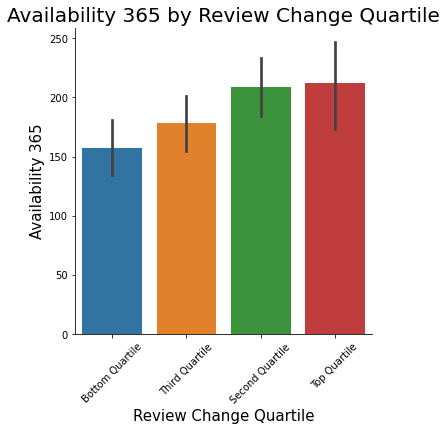

In [118]:
sns.catplot(data = listing_level_data,kind = 'bar' 
            ,x ='review_change_quartile', y = 'availability_365')
plt.title('Availability 365 by Review Change Quartile', size = 20)
plt.xlabel('Review Change Quartile' , size = 15)
plt.ylabel('Availability 365', size = 15)
plt.xticks(rotation=45)

plt.show()

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

all_listings = listing_level_data.dropna()

cols = ['price', 'host_id', 'room_type', 'minimum_nights']

X = all_listings[cols]
y = all_listings.availability_365

X = pd.get_dummies(X)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Accuracy Score
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/Kim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [125]:
predictions = lr.predict(X_train)
metrics.accuracy_score(predictions, y_train)

0.08156028368794327

In [126]:
print(f'Model Error: {metrics.mean_squared_error(lr.predict(X), y)}')
print(f'Benchmark: {metrics.mean_squared_error([y.mean() for i in range(len(y))], y)}')

Model Error: 50184.07365439094
Benchmark: 16066.948856021636


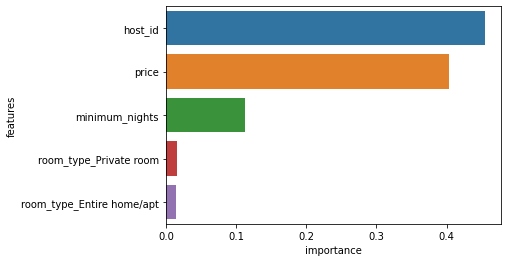

In [127]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

X.columns
rf.feature_importances_[:5]
df = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending= False)
sns.barplot(x = 'importance', y = 'features', data = df.head(10), orient='h')

In [130]:
listing_level_data.groupby('host_id').availability_365.mean()

host_id
28569        292
61692         73
77857         41
103790       350
120950       296
            ... 
198927270     59
207839860    354
212312556    276
248540707     78
356854066     29
Name: availability_365, Length: 354, dtype: int64

In [131]:
listing_level_data.groupby('availability_365').host_id.value_counts()

availability_365  host_id  
0                 130598       1
                  205467       1
                  410450       1
                  552845       1
                  2258135      1
                              ..
365               6015007      1
                  12460464     1
                  18695280     1
                  66279133     1
                  104613882    1
Name: host_id, Length: 354, dtype: int64

### Goal: Determine which words from comment review text are the best predictors of review ratings

### Takeway: Cleaniness, location, space, and parking were important features from review comment text in predicting review ratings

In [132]:
#Vectorizing comment text from reviews

all_reviews = review_level_data.dropna()

comments = all_reviews.comments
cv = CountVectorizer(max_features=250)
comments_cv = cv.fit_transform(comments)
type(comments_cv)
comments_cv.todense()
cv.get_feature_names()
df_comments = pd.DataFrame(comments_cv.todense(), columns = cv.get_feature_names())
CountVectorizer()

#Cleaning review text
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stopwords.words("english")
stop_words = set(stopwords.words("english")+['airbnb','review', 'love', 'like', 'place', 'amaze', 'good', 'great', 'ok', 'best', 'would', 'amazing', 'happy', 'really', "pretty", "get", "decent", "always", "perfect", "stay", "seem", "favorite", "try", "nice", "everything"])

comments[25]
sentence_words = nltk.word_tokenize(comments[25])
sentence_words
' '.join(sentence_words)

comments_stop_words = [i.lower() for i in sentence_words if i.lower() not in stop_words]
sentence_words = nltk.word_tokenize(comments[25])
' '.join(sentence_words)
' '.join(comments_stop_words)

punctuations="?:!.,;-@"
remove_punctuations = [i for i in comments_stop_words if i not in punctuations]
' '.join(remove_punctuations)

#Further cleaning and vectorizing data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

stemmer.stem('running')
stemmer.stem('runs')
stemmer.stem('ran')
stemmed_punctuations = [stemmer.stem(i) for i in remove_punctuations]
remove_punctuations
' '.join(stemmed_punctuations)

def clean_data(text):
    sentence_words = nltk.word_tokenize(text)
    
    comments_stop_words = [i.lower() for i in sentence_words if i.lower() not in stop_words]
    remove_punctuations = [i for i in comments_stop_words if i not in punctuations]
    stemmed_punctuations = [stemmer.stem(i) for i in remove_punctuations]
    
    return ' '.join(stemmed_punctuations)

clean_data(comments[50])
all_reviews['clean_text'] = [clean_data(i) for i in all_reviews.comments]
cv = CountVectorizer(min_df=.0075)
text_cv = cv.fit_transform(all_reviews.clean_text)
vectorized_clean_text = pd.DataFrame(text_cv.todense(), columns = cv.get_feature_names())
vectorized_clean_text.shape

[nltk_data] Downloading package stopwords to /Users/Kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Kim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(44328, 373)

In [133]:
vectorized_clean_text.head()

,10,100,15,20,abl,absolut,access,accommod,ador,air,...,whole,wifi,window,wish,within,without,wonder,work,worth,yard
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,3,0,0,0,1,0,0,1
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
X = vectorized_clean_text
y = all_reviews.aggregate_reviews

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Accuracy Score
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/Kim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [135]:
predictions = lr.predict(X_train)
metrics.accuracy_score(predictions, y_train)

0.7575996841689696

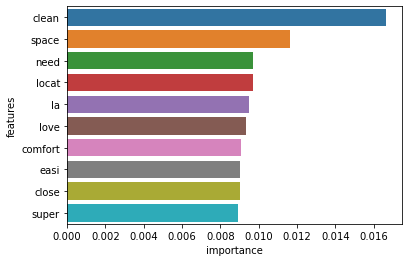

In [136]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

X.columns
rf.feature_importances_[:5]
df = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending= False)
sns.barplot(x = 'importance', y = 'features', data = df.head(10), orient='h')

In [137]:
print(f'Model Error: {metrics.mean_squared_error(lr.predict(X), y)}')
print(f'Benchmark: {metrics.mean_squared_error([y.mean() for i in range(len(y))], y)}')

Model Error: 0.6635309510918607
Benchmark: 0.5564119053438688


In [149]:
#Vectorizing comment text from reviews

all_listings = listing_level_data.dropna()

description = all_listings.description
cv = CountVectorizer(max_features=250)
description_cv = cv.fit_transform(comments)
type(description_cv)
description_cv.todense()
cv.get_feature_names()
df_description = pd.DataFrame(description_cv.todense(), columns = cv.get_feature_names())
CountVectorizer()

#Cleaning review text
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stopwords.words("english")
stop_words = set(stopwords.words("english")+['br', 'airbnb','review', 'love', 'like', 'place', 'amaze', 'good', 'great', 'ok', 'best', 'would', 'amazing', 'happy', 'really', "pretty", "get", "decent", "always", "perfect", "stay", "seem", "favorite", "try", "nice", "everything"])

description[25]
sentence_words = nltk.word_tokenize(comments[25])
sentence_words
' '.join(sentence_words)

description_stop_words = [i.lower() for i in sentence_words if i.lower() not in stop_words]
sentence_words = nltk.word_tokenize(description[25])
' '.join(sentence_words)
' '.join(comments_stop_words)

punctuations="?:!.,;-@"
remove_punctuations = [i for i in description_stop_words if i not in punctuations]
' '.join(remove_punctuations)

#Further cleaning and vectorizing data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

stemmer.stem('running')
stemmer.stem('runs')
stemmer.stem('ran')
stemmed_punctuations = [stemmer.stem(i) for i in remove_punctuations]
remove_punctuations
' '.join(stemmed_punctuations)

def clean_data(text):
    sentence_words = nltk.word_tokenize(text)
    
    description_stop_words = [i.lower() for i in sentence_words if i.lower() not in stop_words]
    remove_punctuations = [i for i in description_stop_words if i not in punctuations]
    stemmed_punctuations = [stemmer.stem(i) for i in remove_punctuations]
    
    return ' '.join(stemmed_punctuations)

clean_data(comments[50])
all_listings['clean_text'] = [clean_data(i) for i in all_listings.description]
cv = CountVectorizer(min_df=.0075)
text_cv = cv.fit_transform(all_listings.clean_text)
vectorized_clean_text = pd.DataFrame(text_cv.todense(), columns = cv.get_feature_names())
vectorized_clean_text.shape

[nltk_data] Downloading package stopwords to /Users/Kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Kim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-149-676d4c98c878>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_listings['clean_text'] = [clean_data(i) for i in all_listings.description]


(353, 1414)

In [150]:
vectorized_clean_text.head()

,10,100,101,10pm,11,12,14,15,150,16,...,yard,year,yes,yet,yoga,york,you,yourself,zen,zoo
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
X = vectorized_clean_text
y = all_listings.review_change

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Accuracy Score
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/Kim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [152]:
predictions = lr.predict(X_train)
metrics.accuracy_score(predictions, y_train)

0.9964539007092199

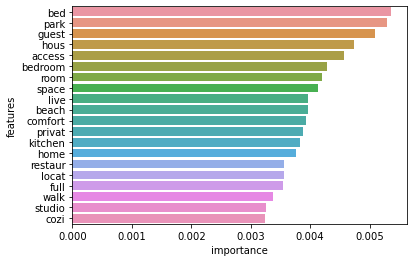

In [158]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

X.columns
rf.feature_importances_[:5]
df = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_})\
                    .sort_values('importance', ascending= False)
sns.barplot(x = 'importance', y = 'features', data = df.head(20), orient='h')

In [148]:
listing_level_data['description'].head()

2     **THIS SUPERHOST IS ANTI-TRUMP** Everyone is w...
8     The unit is about 350 sq. ft. and is the whole...
9     Live the California lifestyle in our grand Spa...
10    Guest House<br /><br /><b>The space</b><br />F...
12    Two-room pool-house in which we will allow you...
Name: description, dtype: object

## PART 4 - RECOMMENDATIONS

Price and number of days the listing is available have the largest impact on review ratings. This holds true before and after COVID 19, with the regression model performing significantly better than the benchmark score in both cases.

While results were not statistically significant, those with higher reviewing ratings had an average price point of 108 dollars per night, whereas those will lower ratings had an average price point of approximately 117 dollars per night.

Airbnbs with higher review ratings were open for an average of 185 to 195 days a year, compared to those will slightly lower ratings, which were open an average of 230 days per year or more.

Identifying the correct price point and number of days open are of particular importance in receiving good ratings. Listings that were available to book only one night also tended to have lower review ratings.

Review comment text indicated that location, clealiness, space, and comfort were all of importance in predicting review ratings. Cleaniess apears to be of particular importance in predicting reviews as the random forrest model found this to be of one of the primary factors in predicting review ratings. This finding held true even prior to COVID 19.